In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import pandas as pd
import numpy as np
import json
import pathlib
import random
import zipfile

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertConfig, AutoTokenizer
from transformers.optimization import AdamW
from transformers import RobertaForSequenceClassification

from scipy.special import expit
from keras.preprocessing.sequence import pad_sequences
from sklearn import metrics
import matplotlib.pyplot as plt

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

def encode_text_pairs(tokenizer, sentences):
    bs = 20000
    input_ids, attention_masks, token_type_ids = [], [], []

    text1_max = int(MAX_LEN * .75)  # leave 75% of token lens to premise text
    for _, i in enumerate(range(0, len(sentences), bs)):
        tokenized_texts = []
        for sentence in sentences[i:i + bs]:
            p1 = [' '] + tokenizer.tokenize(sentence[0])
            p2 = [' '] + tokenizer.tokenize(sentence[1]) + [' ']
            text2_max = MAX_LEN - len(p1[:text1_max])
            final_tokens = p1[:text1_max] + p2[:text2_max]
            tokenized_texts.append(final_tokens)

        b_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
        b_input_ids = pad_sequences(b_input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

        b_token_type_ids = []
        for i, row in enumerate(b_input_ids):
            row = np.array(row)
            mask = row == tokenizer.convert_tokens_to_ids('[SEP]')
            sep_indices = np.where(mask)[0]
            if len(sep_indices) >= 2:
                idx = sep_indices[0]
                idx1 = sep_indices[1]
            else:
                idx = 0
                idx1 = len(row)  # or some default value or handling
            token_type_row = np.zeros(row.shape[0], dtype=np.int64)
            token_type_row[idx + 1:idx1 + 1] = 1
            b_token_type_ids.append(token_type_row)

        b_attention_masks = []
        for seq in b_input_ids:
            seq_mask = [float(i > 0) for i in seq]
            b_attention_masks.append(seq_mask)

        attention_masks.append(b_attention_masks)
        input_ids.append(b_input_ids)
        token_type_ids.append(b_token_type_ids)

    input_ids, attention_masks = np.vstack(input_ids), np.vstack(attention_masks)
    token_type_ids = np.vstack(token_type_ids)

    return input_ids, attention_masks, token_type_ids


MAX_LEN = 512
SEED = 128
seed_everything(SEED)
task_name = 'RuMedDaNet'
device = "cuda" if torch.cuda.is_available() else "cpu"
parts = ['train', 'dev']

l2i = {'нет': 0, 'да': 1}  # labels to indices
text1_id, text2_id, label_id, index_id = 'context', 'question', 'answer', 'pairID'

dummy_label = list(l2i.keys())[0]
data_path = '/kaggle/input/medmed'
part2indices = {p: set() for p in parts}
all_ids, sentences, labels = [], [], []
for p in parts:
    fname = (p + '.json')
    with open(os.path.join(data_path, fname)) as f:
        for line in f:
            data = json.loads(line)
            s1, s2 = data[text1_id], data[text2_id]
            sentences.append((s1, s2))
            labels.append(data.get(label_id, dummy_label))
            idx = data[index_id]
            all_ids.append(idx)
            part2indices[p].add(idx)

all_ids = np.array(all_ids)
i2l = {l2i[l]: l for l in l2i}
tokenizer = AutoTokenizer.from_pretrained("sagteam/xlm-roberta-large-sag")
model = RobertaForSequenceClassification.from_pretrained('sagteam/xlm-roberta-large-sag')

input_ids, attention_masks, token_type_ids = encode_text_pairs(tokenizer, sentences)
label_indices = np.array([l2i[l] for l in labels])
labels = np.zeros((input_ids.shape[0], len(l2i)))
for _, i in enumerate(label_indices):
    labels[_, i] = 1

batch_size = 3
epochs = 15
lr = 1e-5
max_grad_norm = 1.0
cv_res = {}

train_loss_list = []
val_loss_list = []
val_acc_list = []
val_f1_list = []

for fold in range(1):
    best_dev_score = -1
    seed_everything(SEED)
    train_ids = part2indices['train']
    dev_ids = part2indices['dev']

    train_mask = np.array([sid in train_ids for sid in all_ids])
    dev_mask = np.array([sid in dev_ids for sid in all_ids])

    input_ids_train, attention_masks_train, labels_train = input_ids[train_mask], attention_masks[train_mask], labels[train_mask]
    token_type_ids_train = token_type_ids[train_mask]
    input_ids_dev, attention_masks_dev, labels_dev = input_ids[dev_mask], attention_masks[dev_mask], labels[dev_mask]
    token_type_ids_dev = token_type_ids[dev_mask]
    print('fold', fold, input_ids_train.shape, input_ids_dev.shape)

    input_ids_train = torch.tensor(input_ids_train)
    attention_masks_train = torch.tensor(attention_masks_train)
    labels_train = torch.tensor(labels_train)
    token_type_ids_train = torch.tensor(token_type_ids_train)

    train_data = TensorDataset(input_ids_train, attention_masks_train, token_type_ids_train, labels_train)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, worker_init_fn=seed_worker)

    ## prediction_dataloader
    input_ids_dev = torch.tensor(input_ids_dev)
    attention_masks_dev = torch.tensor(attention_masks_dev)
    labels_dev = torch.tensor(labels_dev)
    token_type_ids_dev = torch.tensor(token_type_ids_dev)

    prediction_data = TensorDataset(input_ids_dev, attention_masks_dev, token_type_ids_dev, labels_dev)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size, worker_init_fn=seed_worker)

    model = model.to(device)

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)
    maxf1 = 0
    for i in range(epochs):
        model.train()
        torch.cuda.empty_cache()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch
            b_input_ids, b_input_mask, b_token_type_ids, b_labels = torch.tensor(b_input_ids).to(device), \
            torch.tensor(b_input_mask).to(device), \
            torch.tensor(b_token_type_ids).to(device), \
            torch.tensor(b_labels).to(device)

            optimizer.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
            tr_loss += loss.item()
            train_loss_list.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()

            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
        avg_train_loss = tr_loss / nb_tr_steps

        ### val
        model.eval()
        predictions = []
        tr_loss, nb_tr_steps = 0, 0
        for step, batch in enumerate(prediction_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss, logits = outputs[:2]
                tr_loss += loss.item()
                val_loss_list.append(loss.item())
                nb_tr_steps += 1
            logits = logits.detach().cpu().numpy()
            predictions.append(logits)
        predictions = expit(np.vstack(predictions))
        edev_loss = tr_loss / nb_tr_steps
        
        y_indices, pred = np.argmax(labels_dev, axis=1), np.argmax(predictions, axis=1)
        dev_acc = metrics.accuracy_score(y_indices, pred) * 100
        dev_f1 = metrics.f1_score(y_indices, pred)
        if dev_f1>maxf1:
            torch.save(model.state_dict(), f'xlm-roberta-large-sag_epoch{i}_1e-5.pth')
            maxf1 = dev_f1
        val_acc_list.append(dev_acc)
        val_f1_list.append(dev_f1)
        print()
        print('{} epoch {} average train_loss: {:.6f}\tdev_loss: {:.6f}\tdev_acc {:.2f}\tdev_f1 {:.2f}'.format(task_name, _, avg_train_loss, edev_loss, dev_acc, dev_f1))




2024-06-14 11:18:56.492985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 11:18:56.493086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 11:18:56.632012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sagteam/xlm-roberta-large-sag and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


fold 0 (1308, 512) (256, 512)

RuMedDaNet epoch 0 average train_loss: 0.707862	dev_loss: 0.694758	dev_acc 50.00	dev_f1 0.67

RuMedDaNet epoch 1 average train_loss: 0.701095	dev_loss: 0.686996	dev_acc 50.78	dev_f1 0.65

RuMedDaNet epoch 2 average train_loss: 0.632686	dev_loss: 0.688187	dev_acc 70.70	dev_f1 0.61

RuMedDaNet epoch 3 average train_loss: 0.639517	dev_loss: 0.809306	dev_acc 79.30	dev_f1 0.80

RuMedDaNet epoch 4 average train_loss: 0.464673	dev_loss: 1.145901	dev_acc 74.22	dev_f1 0.70

RuMedDaNet epoch 5 average train_loss: 0.255291	dev_loss: 1.083005	dev_acc 82.81	dev_f1 0.83

RuMedDaNet epoch 6 average train_loss: 0.141631	dev_loss: 1.175762	dev_acc 82.42	dev_f1 0.83

RuMedDaNet epoch 7 average train_loss: 0.066772	dev_loss: 1.522305	dev_acc 79.30	dev_f1 0.79


KeyboardInterrupt: 

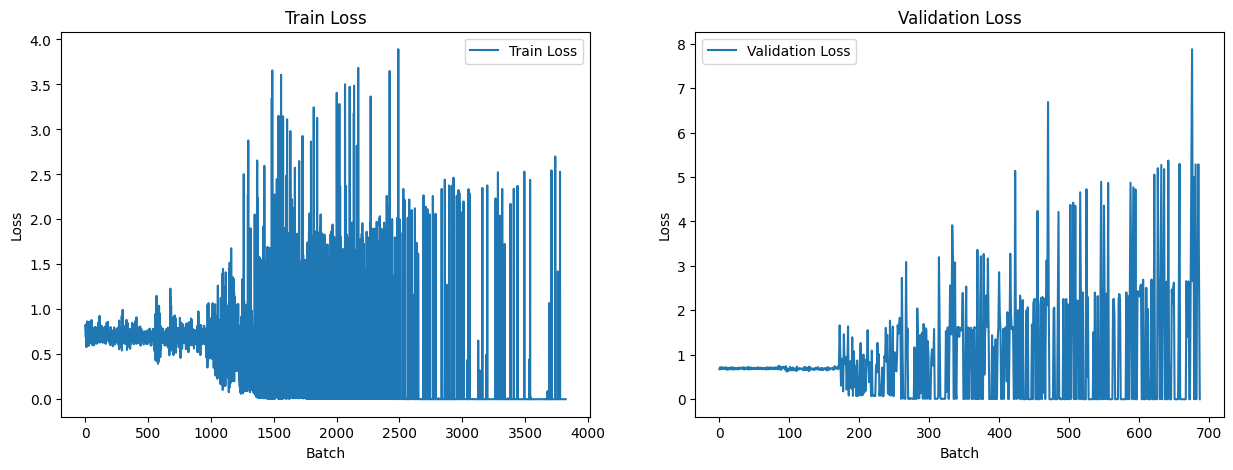

In [2]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

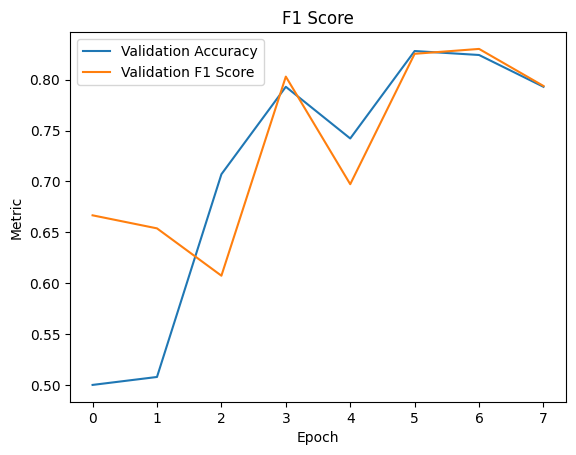

In [3]:

plt.plot([i / 100 for i in val_acc_list], label='Validation Accuracy')
plt.plot(val_f1_list, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('F1 Score')
plt.legend()

plt.show()



In [5]:
def predict(text1, text2):
    model.eval()
    inputs = tokenizer(text1, text2, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LEN).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).item()
    return i2l[pred]

text1 = input("Введите контекст: ")
text2 = input("Введите вопрос: ")
prediction = predict(text1, text2)
print(f"Предсказание: {prediction}")

Введите контекст:  Корь крайне опасная для здоровья и заразная болезнь
Введите вопрос:  Карантин из-за кори является крайне излишней мерой?


Предсказание: нет
